In [1]:
import pyterrier as pt
import pandas as pd
import os
import warnings
warnings.filterwarnings("ignore")

In [2]:
if not pt.started():
    pt.init()

PyTerrier 0.7.1 has loaded Terrier 5.6 (built by craigmacdonald on 2021-09-17 13:27)


In [3]:
pd_indexer = pt.DFIndexer('./index', overwrite=True, blocks=True, verbose=True)
df = pd.read_csv('met_dataset.csv').astype(str).rename(columns={'Object ID': 'docno'})

In [4]:
meta_fields = df[['docno', 'Is Highlight', 'Is Timeline Work', 'Department', 'Title', 'Culture', 'Period', 'Artist Display Name', 'Country', 'Tags', 'image']]
indexref = pd_indexer.index(df["description"], **meta_fields)

34427documents [00:26, 1309.80documents/s]                    


In [5]:
index = pt.IndexFactory.of(indexref)

In [6]:
topics = pd.read_csv('topics.csv').astype(str)
qrels = pd.read_csv('qrels.csv').astype(str)
qrels['label'] = qrels['label'].astype(int)

In [180]:
RANK_CUTOFF = 50
SEED=27

from sklearn.model_selection import train_test_split

tr_va_topics, test_topics = train_test_split(topics, test_size=0.2, random_state=SEED)
train_topics, valid_topics =  train_test_split(tr_va_topics, test_size=0.2, random_state=SEED)

In [181]:
bm25 = pt.BatchRetrieve(index, wmodel="BM25")
sdm = pt.rewrite.SDM()
qe = pt.rewrite.Bo1QueryExpansion(index)

ltr_feats1 = (bm25 % RANK_CUTOFF) >> pt.text.get_text(index, ['Is Highlight', 'Is Timeline Work', 'Department', 'Title', 'Culture', 'Period', 'Artist Display Name', 'Country', 'Tags', 'image']) >> (
    pt.transformer.IdentityTransformer()
    ** # sequential dependence and query expansion
    (sdm >> bm25 >> qe >> bm25)
    ** # score of title (not originally indexed)
    (pt.text.scorer(body_attr="Title", takes='docs', wmodel="DirichletLM") ) 
    ** # score of author (not originally indexed)
    (pt.text.scorer(body_attr="Artist Display Name", takes='docs', wmodel="CoordinateMatch") ) 
    ** # score of tags (not originally indexed)
    (pt.text.scorer(body_attr="Tags", takes='docs', wmodel="DirichletLM") ) 
    ** # score of Country (not originally indexed)
    (pt.text.scorer(body_attr="Country", takes='docs', wmodel="DirichletLM") ) 
    ** # score of Department (not originally indexed)
    (pt.text.scorer(body_attr="Department", takes='docs', wmodel="DirichletLM") ) 
    ** # score of Culture (not originally indexed)
    (pt.text.scorer(body_attr="Culture", takes='docs', wmodel="DirichletLM") ) 
    ** # score of Period (not originally indexed)
    (pt.text.scorer(body_attr="Period", takes='docs', wmodel="DirichletLM") ) 
    ** # is highlited
    (pt.apply.doc_score(lambda row: int(row["Is Highlight"] == 'True')))
    ** # is Timeline Work
    (pt.apply.doc_score(lambda row: int(row["Is Timeline Work"] == 'True')))
    ** # has image
    (pt.apply.doc_score(lambda row: int( row["image"] == '1' ) ))
    ** # Dichichlet Language Model
    pt.BatchRetrieve(index, wmodel="DirichletLM")
)

# for reference, lets record the feature names here too
fnames=["BM25", "SDM and QE", "Title", "Artist Name", "Tags", "Country", "Department", "Culture", "Period", "Is Highlight", "Is Timeline Work", "hasImage" , "DirichletLM"]

In [182]:
import lightgbm as lgb

# this configures LightGBM as LambdaMART
lmart_l = lgb.LGBMRanker(
    task="train",
    silent=False,
    min_data_in_leaf=1,
    min_sum_hessian_in_leaf=1,
    max_bin=255,
    num_leaves=31,
    objective="lambdarank",
    metric="ndcg",
    ndcg_eval_at=[10],
    ndcg_at=[10],
    eval_at=[10],
    learning_rate= .1,
    importance_type="gain",
    num_iterations=100,
    early_stopping_rounds=5
)

lmart_x_pipe = ltr_feats1 >> pt.ltr.apply_learned_model(lmart_l, form="ltr", fit_kwargs={'eval_at':[10]})

%time lmart_x_pipe.fit(train_topics, qrels, valid_topics, qrels)

03:07:44.533 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
03:07:44.667 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
03:07:44.791 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
03:07:44.925 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Def

In [183]:
pt.Experiment(
    [bm25 % RANK_CUTOFF, lmart_x_pipe],
    test_topics,
    qrels, 
    names=["BM25", "BM25 + LMart(7f)"],
    eval_metrics=["ndcg_cut_5", "ndcg_cut_10", "ndcg_cut_20", "ndcg"])

03:07:47.176 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
03:07:47.249 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
03:07:47.318 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
03:07:47.480 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Def

,name,ndcg_cut_5,ndcg_cut_10,ndcg_cut_20,ndcg
0,BM25,0.322932,0.310385,0.284343,0.256477
1,BM25 + LMart(7f),0.487131,0.391346,0.328661,0.282865


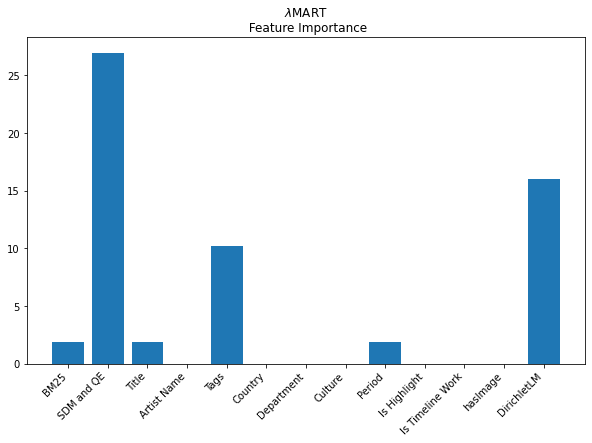

In [184]:
%matplotlib inline
import matplotlib.pyplot as plt, numpy as np

fig, (ax2) = plt.subplots(1, 1, figsize=(10, 6))

ax2.bar(np.arange(len(fnames)), lmart_l.feature_importances_)
ax2.set_xticks(np.arange(len(fnames)))
ax2.set_xticklabels(fnames, rotation=45, ha='right')
ax2.set_title("$\lambda$MART\n Feature Importance")

fig.show()

In [185]:
lmart_x_pipe.search('river and forest')

03:07:48.543 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
03:07:48.625 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
03:07:48.717 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
03:07:48.786 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Def

,qid,docid,docno,score,query,Is Highlight,Is Timeline Work,Department,Title,Culture,Period,Artist Display Name,Country,Tags,image,query_0,features,rank
3,1,672,38036,0.091865,river and forest,False,False,Asian Art,nan,"India (Punjab Hills, Kangra)",nan,nan,nan,Birds Peacocks Deer Men Women,1,river forest #combine:0=0.1:wmodel=org.terrier...,"[12.432252192304809, 11.95729987750299, 0.0, 0...",0
0,1,22867,437684,-0.020772,river and forest,False,False,European Paintings,The Road from Moret to Saint-MammÃ¨s,nan,nan,Alfred Sisley,nan,Houses Roads Forests Human Figures,1,river forest #combine:0=0.1:wmodel=org.terrier...,"[13.784947509100498, 14.938358968916901, 0.0, ...",1
2,1,23706,459114,-0.020772,river and forest,False,False,Robert Lehman Collection,The Pool (Memory of the Forest of Chambord),nan,nan,ThÃ©odore Rousseau,nan,Forests Landscapes,1,river forest #combine:0=0.1:wmodel=org.terrier...,"[12.60247157324802, 15.552282514543561, 0.0133...",2
1,1,16339,383131,-0.070276,river and forest,False,False,Drawings and Prints,"View of Chepstow, Wales",nan,nan,John Scarlett Davis,nan,Rivers Landscapes Trees,1,river forest #combine:0=0.1:wmodel=org.terrier...,"[13.087937816313579, 14.060267232056386, 0.0, ...",3
37,1,22765,437526,-0.195270,river and forest,False,True,European Paintings,A Forest at Dawn with a Deer Hunt,nan,nan,Peter Paul Rubens,nan,Hunting Deer Forests Dawn,1,river forest #combine:0=0.1:wmodel=org.terrier...,"[8.541998579823973, 9.426145145487176, 0.01330...",4
30,1,3929,335045,-0.242288,river and forest,False,False,Drawings and Prints,"Wooded Landscape with a River, Castle, and Tow...",nan,nan,Denijs van Alsloot,nan,Castles Towns Rivers Landscapes Trees,1,river forest #combine:0=0.1:wmodel=org.terrier...,"[8.808882966906761, 9.385173775785319, 0.00828...",5
7,1,23284,438816,-0.275552,river and forest,True,True,European Paintings,The Forest in Winter at Sunset,nan,nan,ThÃ©odore Rousseau,nan,Forests Winter Evening,1,river forest #combine:0=0.1:wmodel=org.terrier...,"[10.653078565186043, 10.653078565186043, 0.013...",6
15,1,3859,334962,-0.275552,river and forest,False,False,Drawings and Prints,Genoveva,nan,nan,Adrian Ludwig Richter,nan,Birds Children Women Rabbits Forests,1,river forest #combine:0=0.1:wmodel=org.terrier...,"[9.669882907980424, 10.20884754792221, 0.0, 0....",7
29,1,3930,335046,-0.275552,river and forest,False,False,Drawings and Prints,Forest Scene with Tree in Foreground,nan,nan,Jacques d'Artois,nan,Forests Trees,1,river forest #combine:0=0.1:wmodel=org.terrier...,"[8.827312212709709, 10.015625818291182, 0.0133...",8
5,1,2118,53230,-0.311894,river and forest,False,False,Asian Art,éªæå¨ç¶ç­ãå±±æ°´å³|Landscape with Roc...,Japan,Muromachi period (1392â?573),Sesson ShÅ«kei,nan,Landscapes,1,river forest #combine:0=0.1:wmodel=org.terrier...,"[11.006450646006737, 10.754855019091924, 0.0, ...",9
